## <font color='darkblue'>Preface</font>
([article](https://machinelearningmastery.com/calculate-feature-importance-with-python/)) **<font size='3ptx'>Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.</font>** There are many types and sources of feature importance scores, although popular examples include statistical correlation scores, coefficients calculated as part of linear models, decision trees, and permutation importance scores.

Feature importance scores play an important role in a predictive modeling project, including providing insight into the data, insight into the model, and the basis for [**dimensionality reduction**](https://machinelearningmastery.com/dimensionality-reduction-for-machine-learning/) and [**feature selection**](https://machinelearningmastery.com/rfe-feature-selection-in-python/) that can improve the efficiency and effectiveness of a predictive model on the problem.

In this tutorial, you will discover feature importance scores for machine learning in python

After completing this tutorial, you will know:
* The role of feature importance in a predictive modeling problem.
* How to calculate and review feature importance from linear models and decision trees.
* How to calculate and review permutation feature importance scores.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into six parts; they are:
* [<font size='3ptx'>**Feature Importance**</font>](#sect1)
* [<font size='3ptx'>**Preparation**</font>](#sect2)
  1. [Check Scikit-Learn Version](#sect2_1)
  2. [Test Datasets](#sect2_2)
* [<font size='3ptx'>**Coefficients as Feature Importance**</font>](#sect3)
  1. [Linear Regression Feature Importance](#sect3_1)
  2. [Logistic Regression Feature Importance](#sect3_2)
* [<font size='3ptx'>**Decision Tree Feature Importance**</font>](#sect4)
  1. [CART Feature Importance](#sect4_1)
  2. [Random Forest Feature Importance](#sect4_2)
  3. [XGBoost Feature Importance](#sect4_3)
* [<font size='3ptx'>**Permutation Feature Importance**</font>](#sect5)
  1. [Permutation Feature Importance for Regression](#sect5_1)
  2. [Permutation Feature Importance for Classification](#sect5_2)
* [<font size='3ptx'>**Feature Selection with Importance**</font>](#sect6)

<a id='sect1'></a>
## <font color='darkblue'>Feature Importance</font>
Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

Feature importance scores can be calculated for problems that involve predicting a numerical value, called regression, and those problems that involve predicting a class label, called classification.

The scores are useful and can be used in a range of situations in a predictive modeling problem, such as:
* Better understanding the data.
* Better understanding a model.
* Reducing the number of input features.

**Feature importance scores can provide insight into the dataset**. The relative scores can highlight which features may be most relevant to the target, and the converse, which features are the least relevant. This may be interpreted by a domain expert and could be used as the basis for gathering more or different data.

**Feature importance scores can provide insight into the model**. Most importance scores are calculated by a predictive model that has been fit on the dataset. Inspecting the importance score provides insight into that specific model and which features are the most important and least important to the model when making a prediction. This is a type of model interpretation that can be performed for those models that support it.

**Feature importance can be used to improve a predictive model**. This can be achieved by using the importance scores to select those features to delete (<font color='brown'>lowest scores</font>) or those features to keep (<font color='brown'>highest scores</font>). This is a type of feature selection and can simplify the problem that is being modeled, speed up the modeling process (<font color='brown'>deleting features is called dimensionality reduction</font>), and in some cases, improve the performance of the model.
> Often, we desire to quantify the strength of the relationship between the predictors and the outcome. […] Ranking predictors in this manner can be very useful when sifting through large amounts of data.<br/><br/>
> [**— Page 463, Applied Predictive Modeling, 2013.**](https://amzn.to/3b2LHTL)

Feature importance scores can be fed to a wrapper model, such as the [**SelectFromModel class**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html), to perform feature selection. There are many ways to calculate feature importance scores and many models that can be used for this purpose.

Perhaps the simplest way is to calculate simple coefficient statistics between each feature and the target variable. For more on this approach, see the tutorial ["How to Choose a Feature Selection Method for Machine Learning"](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/).

In this tutorial, we will look at three main types of more advanced feature importance; they are:
* Feature importance from model coefficients.
* Feature importance from decision trees.
* Feature importance from permutation testing.

<a id='sect2'></a>
## <font color='darkblue'>Preparation</font>
Before we dive in, let’s confirm our environment and prepare some test datasets.

<a id='sect2_1'></a>
### <font color='darkgreen'>Check Scikit-Learn Version</font>
First, confirm that you have a modern version of the scikit-learn library installed. This is important because some of the models we will explore in this tutorial require a modern version of the library.

You can check the version of the library you have installed with the following code example:

In [1]:
import sklearn
print(sklearn.__version__)

0.23.2


Running the example will print the version of the library. At the time of writing, this is about version 0.23.

<a id='sect2_2'></a>
### <font color='darkgreen'>Test Datasets</font>
Next, let’s define some test datasets that we can use as the basis for demonstrating and exploring feature importance scores.

**Each test problem has five important and five unimportant features**, and it may be interesting to see which methods are consistent at finding or differentiating the features based on their importance.

### <font color='darkgreen'>Classification Dataset</font>
We will use the [make_classification()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to create a test binary classification dataset.

The dataset will have 1,000 examples, with 10 input features, five of which will be informative and the remaining five will be redundant. We will fix the random number seed to ensure we get the same examples each time the code is run.

An example of creating and summarizing the dataset is listed below.

In [2]:
# test classification dataset
from sklearn.datasets import make_classification

# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# summarize the dataset
print(X.shape, y.shape)

(1000, 10) (1000,)


### <font color='darkgreen'>Regression Dataset</font>
We will use the [make_regression()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression) function to create a test regression dataset.

Like the classification dataset, the regression dataset will have 1,000 examples, with 10 input features, five of which will be informative and the remaining five that will be redundant.

In [3]:
# test regression dataset
from sklearn.datasets import make_regression

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1000, 10) (1000,)


<a id='sect3'></a>
## <font color='darkblue'>Coefficients as Feature Importance</font>
Linear machine learning algorithms fit a model where the prediction is the weighted sum of the input values. Examples include linear regression, logistic regression, and extensions that add regularization, such as ridge regression and the elastic net.

All of these algorithms find a set of coefficients to use in the weighted sum in order to make a prediction. These coefficients can be used directly as a crude type of feature importance score.

**Let’s take a closer look at using coefficients as feature importance for classification and regression**. We will fit a model on the dataset to find the coefficients, then summarize the importance scores for each input feature and finally create a bar chart to get an idea of the relative importance of the features.

<a id='sect3_1'></a>
### <font color='darkgreen'>Linear Regression Feature Importance</font>
We can fit a [**LinearRegression model**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) on the regression dataset and retrieve the <font color='violet'>coeff_</font> property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. **This assumes that the input variables have the same scale or have been scaled prior to fitting a model.**

The complete example of linear regression coefficients for feature importance is listed below.

Feature: 0, Score: -0.00000
Feature: 1, Score: 12.44483
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 93.32225
Feature: 5, Score: 86.50811
Feature: 6, Score: 26.74607
Feature: 7, Score: 3.28535
Feature: 8, Score: 0.00000
Feature: 9, Score: -0.00000


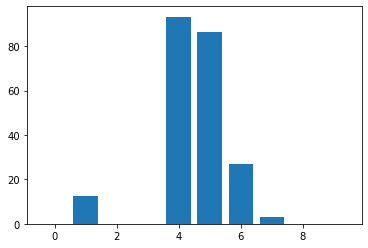

In [6]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# define the model
model = LinearRegression()

# fit the model
model.fit(X, y)

# get importance
importance = model.coef_

# summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show();

The scores suggest that the model found the five important features and marked all other features with a zero coefficient, essentially removing them from the model. This approach may also be used with [**Ridge**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) and [**ElasticNet**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) models.

<a id='sect3_2'></a>
### <font color='darkgreen'>Logistic Regression Feature Importance</font>
We can fit a [**LogisticRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model on the regression dataset and retrieve the <font color='violet'>coeff_</font> property that contains the coefficients found for each input variable. These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.

The complete example of logistic regression coefficients for feature importance is listed below.

Feature: 0, Score: 0.16320
Feature: 1, Score: -0.64301
Feature: 2, Score: 0.48497
Feature: 3, Score: -0.46190
Feature: 4, Score: 0.18432
Feature: 5, Score: -0.11978
Feature: 6, Score: -0.40602
Feature: 7, Score: 0.03772
Feature: 8, Score: -0.51785
Feature: 9, Score: 0.26540


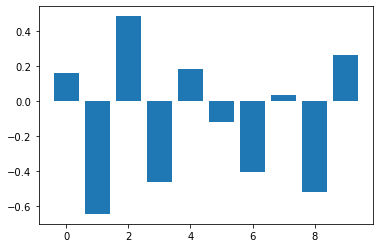

In [8]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# define the model
model = LogisticRegression()

# fit the model
model.fit(X, y)

# get importance
importance = model.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. **The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.**

No clear pattern of important and unimportant features can be identified from these results, at least from what I can tell. Now that we have seen the use of coefficients as importance scores, let’s look at the more common example of decision-tree-based importance scores.

<a id='sect4'></a>
## <font color='darkblue'>Decision Tree Feature Importance</font>
Decision tree algorithms like [**classification and regression trees**](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/) (<font color='brown'>CART</font>) offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy. This same approach can be used for ensembles of decision trees, such as the random forest and stochastic gradient boosting algorithms.

<a id='sect4_1'></a>
### <font color='darkgreen'>CART Feature Importance</font>
We can use the CART algorithm for feature importance implemented in scikit-learn as the [**DecisionTreeRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [**DecisionTreeClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classes. After being fit, the model provides a <font color='violet'>feature_importances_</font> property that can be accessed to retrieve the relative importance scores for each input feature.

#### CART Regression Feature Importance
The complete example of fitting a [**DecisionTreeRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and summarizing the calculated feature importance scores is listed below.

Feature: 0, Score: 0.00283
Feature: 1, Score: 0.00441
Feature: 2, Score: 0.00235
Feature: 3, Score: 0.00188
Feature: 4, Score: 0.51686
Feature: 5, Score: 0.43843
Feature: 6, Score: 0.02682
Feature: 7, Score: 0.00260
Feature: 8, Score: 0.00288
Feature: 9, Score: 0.00093


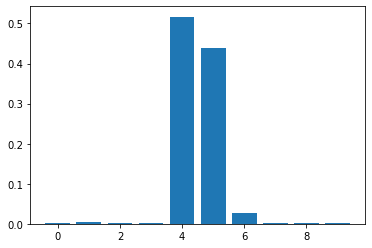

In [9]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# define the model
model = DecisionTreeRegressor()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### CART Classification Feature Importance
The complete example of fitting a [**DecisionTreeClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and summarizing the calculated feature importance scores is listed below.

Feature: 0, Score: 0.01941
Feature: 1, Score: 0.02288
Feature: 2, Score: 0.18340
Feature: 3, Score: 0.30786
Feature: 4, Score: 0.09851
Feature: 5, Score: 0.00832
Feature: 6, Score: 0.17062
Feature: 7, Score: 0.03388
Feature: 8, Score: 0.12487
Feature: 9, Score: 0.03025


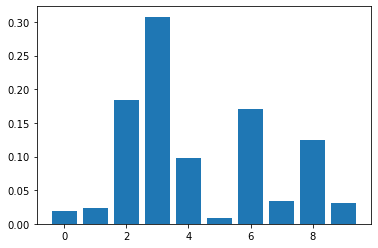

In [10]:
# decision tree for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# define the model
model = DecisionTreeClassifier()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<a id='sect4_2'></a>
### <font color='darkgreen'>Random Forest Feature Importance</font>
We can use the [Random Forest](https://machinelearningmastery.com/implement-random-forest-scratch-python/) algorithm for feature importance implemented in scikit-learn as the [**RandomForestRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [**RandomForestClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classes. After being fit, the model provides a <font color='violet'>feature_importances_</font> property that can be accessed to retrieve the relative importance scores for each input feature.

This approach can also be used with the bagging and extra trees algorithms.

#### Random Forest Regression Feature Importance
The complete example of fitting a [**RandomForestRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and summarizing the calculated feature importance scores is listed below.

Feature: 0, Score: 0.00294
Feature: 1, Score: 0.00559
Feature: 2, Score: 0.00297
Feature: 3, Score: 0.00305
Feature: 4, Score: 0.52893
Feature: 5, Score: 0.42141
Feature: 6, Score: 0.02639
Feature: 7, Score: 0.00276
Feature: 8, Score: 0.00312
Feature: 9, Score: 0.00284


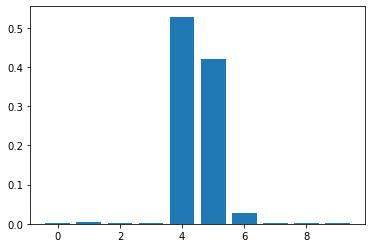

In [11]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# define the model
model = RandomForestRegressor()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Random Forest Classification Feature Importance
The complete example of fitting a [**RandomForestClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and summarizing the calculated feature importance scores is listed below.

Feature: 0, Score: 0.07047
Feature: 1, Score: 0.11288
Feature: 2, Score: 0.14955
Feature: 3, Score: 0.19332
Feature: 4, Score: 0.08140
Feature: 5, Score: 0.10700
Feature: 6, Score: 0.09635
Feature: 7, Score: 0.04981
Feature: 8, Score: 0.09283
Feature: 9, Score: 0.04639


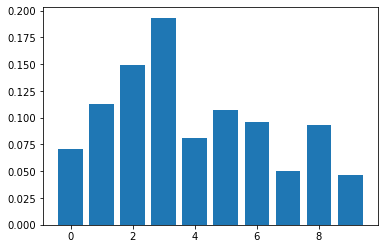

In [12]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# define the model
model = RandomForestClassifier()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<a id='sect4_3'></a>
### <font color='darkgreen'>XGBoost Feature Importance</font>
[**XGBoost**](https://xgboost.readthedocs.io/en/latest/) is a library that provides an efficient and effective implementation of the stochastic gradient boosting algorithm. This algorithm can be used with scikit-learn via the XGBRegressor and XGBClassifier classes.

After being fit, the model provides a <font color='violet'>feature_importances_</font> property that can be accessed to retrieve the relative importance scores for each input feature. This algorithm is also provided via scikit-learn via the [**GradientBoostingClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [**GradientBoostingRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) classes and the same approach to feature selection can be used.

First, install the XGBoost library, such as with pip:

In [13]:
!pip install xgboost

You should consider upgrading via the 'c:\users\johnlee\appdata\local\programs\python\python36\python.exe -m pip install --upgrade pip' command.


Then confirm that the library was installed correctly and works by checking the version number:

In [14]:
import xgboost
print(xgboost.__version__)

1.1.1


#### XGBoost Regression Feature Importance
The complete example of fitting a [**XGBRegressor**](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) and summarizing the calculated feature importance scores is listed below.

Feature: 0, Score: 0.00039
Feature: 1, Score: 0.00583
Feature: 2, Score: 0.00112
Feature: 3, Score: 0.00129
Feature: 4, Score: 0.49502
Feature: 5, Score: 0.46443
Feature: 6, Score: 0.02951
Feature: 7, Score: 0.00086
Feature: 8, Score: 0.00075
Feature: 9, Score: 0.00079


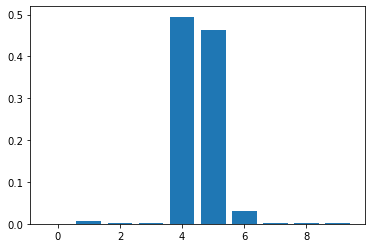

In [15]:
# xgboost for feature importance on a regression problem
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# define the model
model = XGBRegressor()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### XGBoost Classification Feature Importance
The complete example of fitting an [**XGBClassifier**](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRFClassifier) and summarizing the calculated feature importance scores is listed below.

Feature: 0, Score: 0.03723
Feature: 1, Score: 0.07725
Feature: 2, Score: 0.12537
Feature: 3, Score: 0.29666
Feature: 4, Score: 0.10099
Feature: 5, Score: 0.05706
Feature: 6, Score: 0.13027
Feature: 7, Score: 0.03537
Feature: 8, Score: 0.11694
Feature: 9, Score: 0.02285


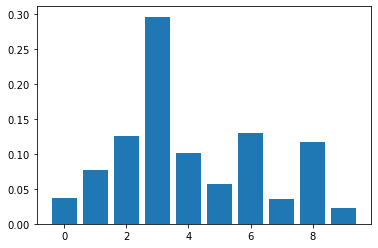

In [16]:
# xgboost for feature importance on a classification problem
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# define the model
model = XGBClassifier()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<a id='sect5'></a>
## <font color='darkblue'>Permutation Feature Importance</font>
[**Permutation feature importance**](https://scikit-learn.org/stable/modules/permutation_importance.html) is a technique for calculating relative importance scores that is independent of the model used.

First, a model is fit on the dataset, such as a model that does not support native feature importance scores. Then the model is used to make predictions on a dataset, although the values of a feature (<font color='brown'>column</font>) in the dataset are scrambled. This is repeated for each feature in the dataset. Then this whole process is repeated 3, 5, 10 or more times. The result is a mean importance score for each input feature (<font color='brown'>and distribution of scores given the repeats</font>).

This approach can be used for regression or classification and requires that a performance metric be chosen as the basis of the importance score, such as the mean squared error for regression and accuracy for classification.

Permutation feature selection can be used via the [permutation_importance()](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) function that takes a fit model, a dataset (<font color='brown'>train or test dataset is fine</font>), and a scoring function. Let’s take a look at this approach to feature selection with an algorithm that does not support feature selection natively, specifically [k-nearest neighbors](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/).

<a id='sect5_1'></a>
### <font color='darkgreen'>Permutation Feature Importance for Regression</font>
The complete example of fitting a [**KNeighborsRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) and summarizing the calculated permutation feature importance scores is listed below.

Feature: 0, Score: 118.37809
Feature: 1, Score: 350.19459
Feature: 2, Score: 170.61476
Feature: 3, Score: 73.29832
Feature: 4, Score: 9405.12668
Feature: 5, Score: 7992.64430
Feature: 6, Score: 933.99287
Feature: 7, Score: 174.17950
Feature: 8, Score: 151.51481
Feature: 9, Score: 117.79557


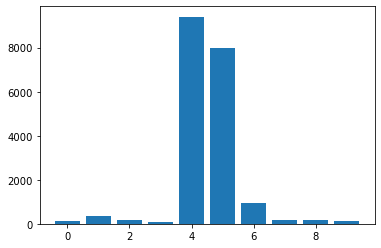

In [18]:
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# define the model
model = KNeighborsRegressor()

# fit the model
model.fit(X, y)

# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<a id='sect5_2'></a>
### <font color='darkgreen'>Permutation Feature Importance for Classification</font>
The complete example of fitting a [**KNeighborsClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and summarizing the calculated permutation feature importance scores is listed below.

Feature: 0, Score: 0.05160
Feature: 1, Score: 0.06240
Feature: 2, Score: 0.05040
Feature: 3, Score: 0.08520
Feature: 4, Score: 0.04980
Feature: 5, Score: 0.05620
Feature: 6, Score: 0.08320
Feature: 7, Score: 0.05080
Feature: 8, Score: 0.05980
Feature: 9, Score: 0.02960


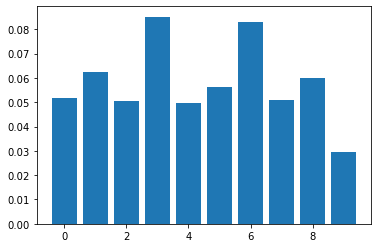

In [19]:
# permutation feature importance with knn for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# define the model
model = KNeighborsClassifier()

# fit the model
model.fit(X, y)

# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')

# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<a id='sect6'></a>
## <font color='darkblue'>Feature Selection with Importance</font>
**Feature importance scores can be used to help interpret the data, but they can also be used directly to help rank and select features that are most useful to a predictive model.** We can demonstrate this with a small example.

Recall, our synthetic dataset has 1,000 examples each with 10 input variables, five of which are redundant and five of which are important to the outcome. We can use feature importance scores to help select the five variables that are relevant and only use them as inputs to a predictive model.

First, we can split the training dataset into train and test sets and train a model on the training dataset, make predictions on the test set and evaluate the result using classification accuracy. We will use a logistic regression model as the predictive model.

This provides a baseline for comparison when we remove some features using feature importance scores. The complete example of evaluating a logistic regression model using all features as input on our synthetic dataset is listed below.

In [20]:
# evaluation of a model using all features
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# define the dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 84.55


In this case we can see that the model achieved the classification accuracy of about 84.55 percent using all features in the dataset. Given that we created the dataset, we would expect better or the same results with half the number of input variables.

We could use any of the feature importance scores explored above, but in this case we will use the feature importance scores provided by random forest.

We can use the [**SelectFromModel**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) class to define both the model we wish to calculate importance scores, [**RandomForestClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) in this case, and the number of features to select, 5 in this case.

In [22]:
from sklearn.feature_selection import SelectFromModel

# configure to select a subset of features
fs = SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=5)

We can fit the feature selection method on the training dataset.

This will calculate the importance scores that can be used to rank all input features. **We can then apply the method as a transform to select a subset of 5 most important features from the dataset**. This transform will be applied to the training dataset and the test set.

In [23]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
 
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=5)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# define the dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)

# evaluate the model
yhat = model.predict(X_test_fs)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 84.55


In this case, we can see that the model achieves the same performance on the dataset, although with half the number of input features. As expected, the feature importance scores calculated by random forest allowed us to accurately rank the input features and delete those that were not relevant to the target variable.

## <font color='darkblue'>Further Reading</font>
This section provides more resources on the topic if you are looking to go deeper.
* [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
* [How to Perform Feature Selection with Categorical Data](https://machinelearningmastery.com/feature-selection-with-categorical-data/)
* [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)
* [Feature Selection For Machine Learning in Python](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
* [An Introduction to Feature Selection](https://machinelearningmastery.com/an-introduction-to-feature-selection/)